## SVM
- 数据集

$$sklearn.datasets.make\_blobs$$

- 损失函数

$$\min\limits_{\alpha}\frac{1}{2}\sum\limits_{i=1}^N\sum\limits_{j=1}^N\alpha_i\alpha_jy_iy_jK(x_i \cdot x_j)-\sum\limits_{i=1}^N\alpha_i$$
$$s.t.\sum\limits_{i=1}^N\alpha_iy_i=0$$
$$0\leq \alpha_i \leq C,i=1,2,\cdots,N$$

- SMO
$$g(x)=\sum\limits_{i=1}^N\alpha_i y_iK(x_i,x)+b$$
$$E_i=g(x_i)-y_i$$
$$\alpha_j^{new}=\alpha_j^{old}+\frac{y_j(E_j-E_i)}{K_{ii}+K_{jj}-2K_{ij}}$$
$$
L=
\begin{cases}
max(0,\alpha_j^{old}-\alpha_i^{old})& \text{$y_i\ne y_j$}\\
max(0,\alpha_j^{old}+\alpha_i^{old}-C)& \text{$y_i= y_j$}
\end{cases}
$$
$$
H=
\begin{cases}
min(C,C+\alpha_j^{old}-\alpha_i^{old})& \text{$y_i\ne y_j$}\\
min(C,\alpha_j^{old}+\alpha_i^{old})& \text{$y_i= y_j$}
\end{cases}
$$
$$
\alpha_j^{new}=
\begin{cases}
H& \text{$\alpha_j^{new}\ge H$}\\
\alpha_j^{new}& \text{$L \le \alpha_j^{new} \le H$}\\
L& \text{$\alpha_j^{new}\le H$}
\end{cases}
$$
$$\alpha_i^{new}=\alpha_{old}+y_iy_j(\alpha_j^{old}-\alpha_j^{new})$$
$$b_i^{new}=-E_i-y_iK_{ii}(\alpha_i^{new}-\alpha_i^{old})-y_jK_{ij}(\alpha_j^{new}-\alpha_j^{old})+b^{old}$$
$$b_j^{new}=-E_j-y_iK_{ij}(\alpha_i^{new}-\alpha_i^{old})-y_jK_{jj}(\alpha_j^{new}-\alpha_j^{old})+b^{old}$$
$$
b^{new}=
\begin{cases}
b_i^{new}& \text{$0 < \alpha_i^{new} < C$}\\
b_j^{new}& \text{$0 < \alpha_j^{new} < C$}\\
(b_i^{new}+b_j^{new}) *0.5& \text{otherwise}
\end{cases}
$$
- 输出

$$f(x)=sign(\sum\limits_{i=1}^N\alpha_i^*y_i(x \cdot x_i)+b^*)$$

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings
from sklearn.datasets import make_moons
from sklearn.datasets import make_blobs
from sklearn.model_selection import train_test_split
warnings.filterwarnings('ignore')

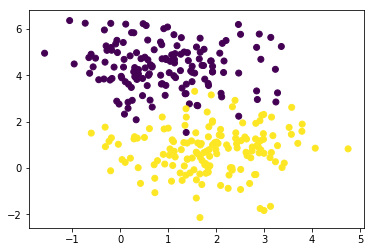

In [2]:
X,Y=make_blobs(n_samples=300,centers=2,random_state=0)
Train_x,Val_x,Train_y,Val_y=train_test_split(X,Y,test_size=0.2)
plt.scatter(X[:,0],X[:,1],c=Y)

In [3]:
class SVM():
    def __init__(self,N,epoch,C):
        self.N=N 
        self.epoch=epoch
        self.b=0
        self.C=C
        self.alpha=np.zeros(N)
    def choose_alpha(self,i):
        j=i
        while i==j:
            j=np.random.randint(self.N)
        return j
    def rbf(self,x,y):
        u=x-y
        return np.exp(-1*(np.dot(u,u)/1))
    def fit(self,X,Y):
        for epoch in range(self.epoch):
            for i in range(self.N):
                j=self.choose_alpha(i)
                E_i=E_j=self.b
                for x,y in zip(X,Y):
                    E_i+=self.alpha[i]*y*self.rbf(x,X[i])
                    E_j+=self.alpha[i]*y*self.rbf(x,X[j])
                E_i=E_i-Y[i]
                E_j=E_j-Y[j]
                if Y[i]!=Y[j]:
                    L=max(0,self.alpha[j]-self.alpha[i])
                    H=min(self.C,self.C+self.alpha[j]-self.alpha[i])
                else:
                    L=max(0,self.alpha[j]+self.alpha[i]-self.C)
                    H=min(self.C,self.alpha[j]+self.alpha[i])
                K_ii=self.rbf(X[i],X[i])
                K_ij=self.rbf(X[i],X[j])
                K_jj=self.rbf(X[j],X[j])
                alpha_j_new=self.alpha[j]+Y[j]*(E_i-E_j)/(K_ii+K_jj-2*K_ij)
                if alpha_j_new>H:
                    alpha_j_new=H
                elif alpha_j_new<L:
                    alpha_j_new=L
                alpha_i_new=self.alpha[i]+Y[i]*Y[j]*(self.alpha[j]-alpha_j_new)
                b_i=-E_i-Y[i]*K_ii*(alpha_i_new-self.alpha[i])-Y[j]*K_ij*(alpha_j_new-self.alpha[j])+self.b
                b_j=-E_j-Y[i]*K_ij*(alpha_i_new-self.alpha[i])-Y[j]*K_jj*(alpha_j_new-self.alpha[j])+self.b
                if alpha_i_new>0 and alpha_i_new<self.C:
                    self.b=b_i
                elif alpha_j_new>0 and alpha_j_new<self.C:
                    self.b=b_j
                else:
                    self.b=(b_i+b_j)/2
                self.alpha[i]=alpha_i_new
                self.alpha[j]=alpha_j_new
        self.alpha=self.alpha*Y
    def predict(self,train_x,test_x):
        K=np.zeros((train_x.shape[0],test_x.shape[0]))
        for i in range(train_x.shape[0]):
            for j in range(test_x.shape[0]):
                K[i][j]=self.rbf(train_x[i],test_x[j])
        y=np.dot(self.alpha,K)+self.b
        y[y>=0],y[y<0]=1,0
        return y

In [4]:
clf=SVM(Train_x.shape[0],epoch=50,C=0.5)
clf.fit(Train_x,Train_y)

Y=clf.predict(Train_x,Train_x)
print("After Train,Acc: %lf%%"%(sum(Y==Train_y)/len(Train_x)*100))
Y=clf.predict(Train_x,Val_x)
print("Val acc %lf%%"%(sum(Y==Val_y)/len(Val_x)*100))

After Train,Acc: 89.583333%
Val acc 91.666667%


### sklearn.svm.SVC

In [5]:
from sklearn.svm import SVC
clf=SVC(kernel='rbf')
clf.fit(Train_x,Train_y)
Y=clf.predict(Train_x)
print("After Train,Acc: %lf%%"%(sum(Y==Train_y)/len(Train_x)*100))
Y=clf.predict(Val_x)
print("Val acc %lf%%"%(sum(Y==Val_y)/len(Val_x)*100))

After Train,Acc: 97.500000%
Val acc 98.333333%
